Bu notebook'un amacı ve içeriği hakkında daha fazla bilgi için "RNN Models - Main" notebook'unu inceleyiniz.

# Setup

In [1]:
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.autograd import Variable
from torchviz import make_dot

from tqdm import tqdm 

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.dates as mdates

In [2]:
data_seed = 12

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# PHASE 1: Load Data 

In [5]:
df = pd.read_csv(r"DATASETS\ForForecast.csv")
df['TransactionDateTime'] = pd.to_datetime(df['TransactionDateTime'])
df.set_index('TransactionDateTime', inplace=True)
df = df.sort_index()

print(f"Shape {df.shape}")
df.tail(10)

Shape (13499, 19)


ChannelKey  DataAreaKey InventKey InventLocationKey  \
TransactionDateTime                                                        
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   

                    CampaignKrcKey  SalesQuantity  SalesGrossAmount  \
TransactionDateTime                                                   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.51   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.52   
2024-02-08 22:12:00           6414            1.0            115.91   
2024-02-08 22:28:00            -99            1.0            110.49   
2024-02-08 22:28:00           6415            3.0            101.99   
2024-02-08 22:28:00              2            1.0            297.49   
2024-02-08 22:28:00            -99            1.0             84.99   
2024-02-08 22:28:00            -99            2.0            305.99   

                     Return_Quantity  NetQuantity  NetGrossAmount  \
TransactionDateTime                                                 
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.51   
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.52   
2024-02-08 22:12:00              0.0          1.0          115.91   
2024-02-08 22:28:00              0.0          1.0          110.49   
2024-02-08 22:28:00              0.0          3.0          101.99   
2024-02-08 22:28:00              0.0          1.0          297.49   
2024-02-08 22:28:00              0.0          1.0           84.99   
2024-02-08 22:28:00              0.0          2.0          305.99   

                     ReturnGrossAmount  ReturnNetAmount  NetAmountWOVat  \
TransactionDateTime                                                       
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.26   
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.27   
2024-02-08 22:12:00                0.0              0.0           96.59   
2024-02-08 22:28:00                0.0              0.0           92.07   
2024-02-08 22:28:00                0.0              0.0           84.99   
2024-02-08 22:28:00                0.0              0.0          270.45   
2024-02-08 22:28:00                0.0              0.0           70.83   
2024-02-08 22:28:00                0.0              0.0          254.99   

                     DiscountAmount  DiscountGrossAmount RboStoreKey  \
TransactionDateTime                                                    
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.07               343.07      others   
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.06               343.06      others   
2024-02-08 22:12:00          213.49               213.49      others   
2024-02-08 22:28:00  

In [6]:
df.dtypes

ChannelKey               int64
DataAreaKey              int64
InventKey               object
InventLocationKey       object
CampaignKrcKey          object
SalesQuantity          float64
SalesGrossAmount       float64
Return_Quantity        float64
NetQuantity            float64
NetGrossAmount         float64
ReturnGrossAmount      float64
ReturnNetAmount        float64
NetAmountWOVat         float64
DiscountAmount         float64
DiscountGrossAmount    float64
RboStoreKey             object
NetAmount              float64
HourIntervalKey          int64
IsFirstOrder              bool
dtype: object

# PHASE 2: Prepare Data

## Resample and fix

In [7]:
desired_column = 'NetAmountWOVat'

In [8]:
df = df[[desired_column]]

In [9]:
resampled_df = df.resample('60T', closed="left").sum()
resampled_df.shape

(206, 1)

In [10]:
resampled_df.head(10)

NetAmountWOVat
TransactionDateTime                
2024-01-31 09:00:00         7444.94
2024-01-31 10:00:00        16321.85
2024-01-31 11:00:00        16112.86
2024-01-31 12:00:00         9955.61
2024-01-31 13:00:00        36883.48
2024-01-31 14:00:00        11374.87
2024-01-31 15:00:00        49252.87
2024-01-31 16:00:00        65630.39
2024-01-31 17:00:00        31425.66
2024-01-31 18:00:00        39486.80

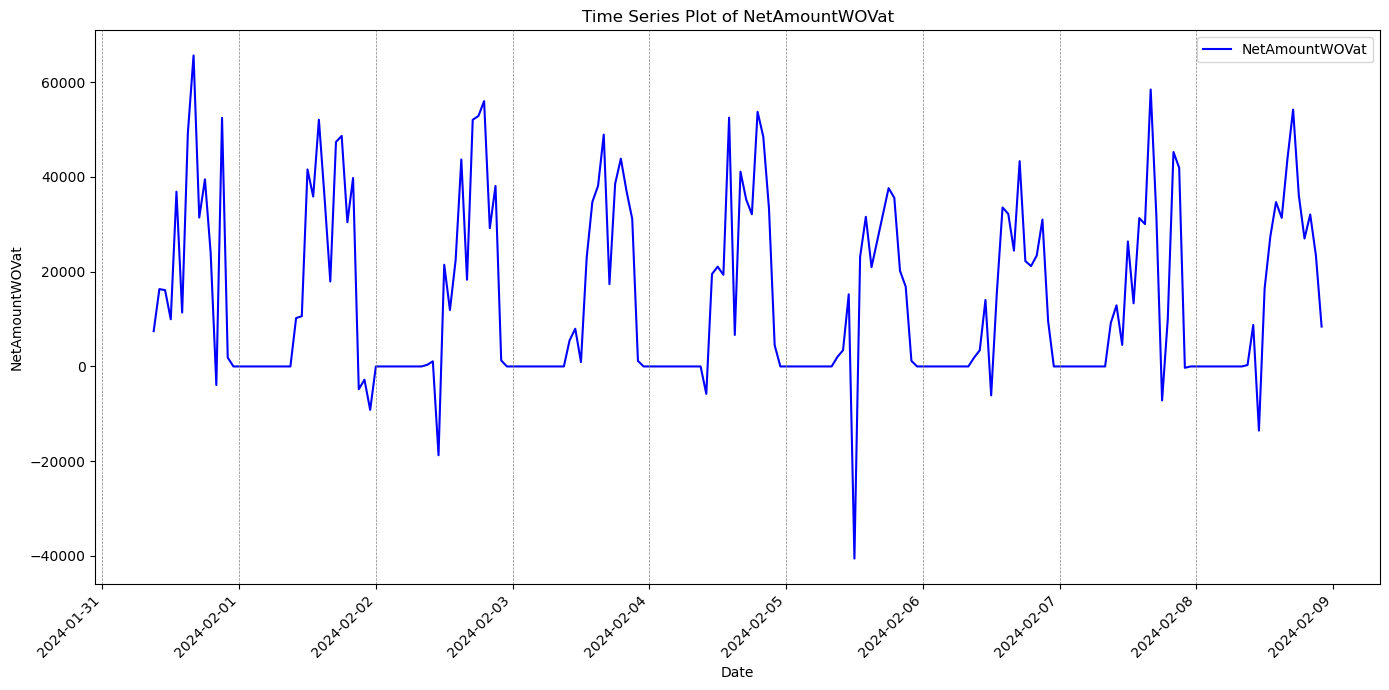

In [11]:
plt.figure(figsize=(14, 7))

plt.plot(resampled_df.index, resampled_df[f'{desired_column}'], label=f'{desired_column}', color='blue')

plt.xlabel('Date')
plt.ylabel(f'{desired_column}')
plt.title(f'Time Series Plot of {desired_column}')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, ha='right')

for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout() 
plt.show()

In [12]:
Q1 = resampled_df[desired_column].quantile(0.25)
Q3 = resampled_df[desired_column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1 * IQR

outliers = resampled_df[(resampled_df[desired_column] < lower_bound) | (resampled_df[desired_column] > upper_bound)]

resampled_df = resampled_df[(resampled_df[desired_column] >= lower_bound) & (resampled_df[desired_column] <= upper_bound)]

print("Number of outliers removed:", len(outliers))
print("DataFrame size after removing outliers:", len(resampled_df))

Number of outliers removed: 2
DataFrame size after removing outliers: 204


In [13]:
resampled_df["HourInterval"] = resampled_df.index.hour
resampled_df['DayOfWeek'] = resampled_df.index.dayofweek + 1

resampled_df[f'{desired_column} Before'] = resampled_df[f'{desired_column}'].shift(1)

resampled_df = resampled_df.dropna()

In [14]:
print(resampled_df.shape)
resampled_df.head()

(203, 4)


NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-01-31 10:00:00        16321.85            10          3   
2024-01-31 11:00:00        16112.86            11          3   
2024-01-31 12:00:00         9955.61            12          3   
2024-01-31 13:00:00        36883.48            13          3   
2024-01-31 14:00:00        11374.87            14          3   

                     NetAmountWOVat Before  
TransactionDateTime                         
2024-01-31 10:00:00                7444.94  
2024-01-31 11:00:00               16321.85  
2024-01-31 12:00:00               16112.86  
2024-01-31 13:00:00                9955.61  
2024-01-31 14:00:00               36883.48

In [15]:
sequence_length = 1
features = ['HourInterval', 'DayOfWeek', f'{desired_column} Before']

## Train-Test Split

In [16]:
train_ratio = 0.8
train_size = int(len(resampled_df) * train_ratio)

train_df = resampled_df[:train_size]
valid_df = resampled_df[train_size:]

In [17]:
print("Train size:", train_size, "Valid Size:", len(resampled_df) - train_size)

Train size: 162 Valid Size: 41


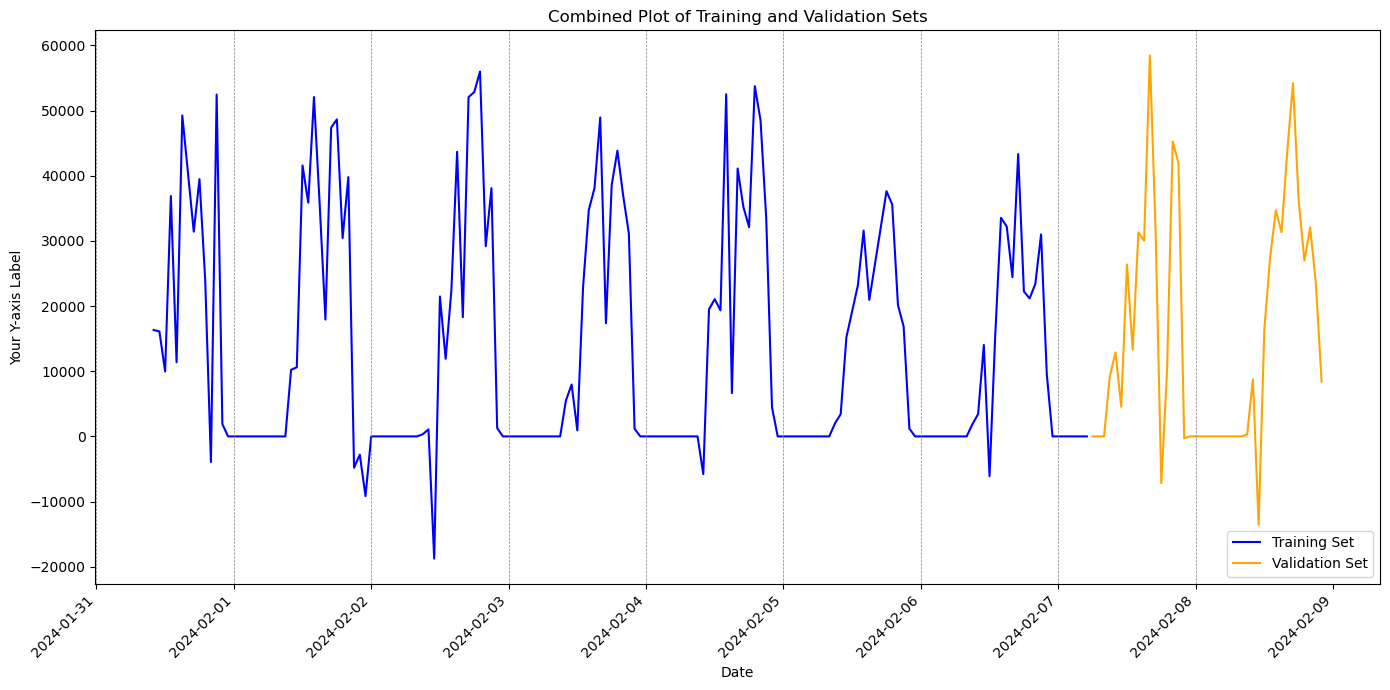

In [18]:
plt.figure(figsize=(14, 7))

plt.plot(train_df.index, train_df[f'{desired_column}'], label='Training Set', color='blue')
plt.plot(valid_df.index, valid_df[f'{desired_column}'], label='Validation Set', color='orange')

plt.xlabel('Date')
plt.ylabel('Your Y-axis Label')
plt.title('Combined Plot of Training and Validation Sets')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, ha='right')

for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

## Normalization

In [19]:
train_original = train_df.copy()
valid_original = valid_df.copy()
train_original_stats = train_original.describe().to_dict()

train_original.describe()

NetAmountWOVat  HourInterval   DayOfWeek  NetAmountWOVat Before
count      162.000000    162.000000  162.000000             162.000000
mean     13545.942778     11.567901    4.049383           13591.899198
std      17835.364789      7.031320    2.021015           17809.817537
min     -18747.920000      0.000000    1.000000          -18747.920000
25%          0.000000      5.000000    2.000000               0.000000
50%       1226.130000     12.000000    4.000000            1561.635000
75%      28517.032500     18.000000    6.000000           28517.032500
max      55993.660000     23.000000    7.000000           55993.660000

In [20]:
with open("normalization_stats.json", "w") as json_file:
    json.dump(train_original[f"{desired_column}"].describe().to_dict(), json_file)

In [21]:
for column in train_df:
    if column in ['HourInterval', 'DayOfWeek']:
        continue
        
    train_df[column] = (train_df[column] - train_original[f'{desired_column}'].mean()) / train_original[f'{desired_column}'].std()
    
for column in valid_df:
    if column in ['HourInterval', 'DayOfWeek']:
        continue

    valid_df[column] = (valid_df[column] - train_original[f'{desired_column}'].mean()) / train_original[f'{desired_column}'].std()

In [22]:
train_df.describe()

NetAmountWOVat  HourInterval   DayOfWeek  NetAmountWOVat Before
count    1.620000e+02    162.000000  162.000000             162.000000
mean    -2.741291e-17     11.567901    4.049383               0.002577
std      1.000000e+00      7.031320    2.021015               0.998568
min     -1.810665e+00      0.000000    1.000000              -1.810665
25%     -7.594991e-01      5.000000    2.000000              -0.759499
50%     -6.907519e-01     12.000000    4.000000              -0.671941
75%      8.394047e-01     18.000000    6.000000               0.839405
max      2.379975e+00     23.000000    7.000000               2.379975

In [23]:
valid_df.describe()

NetAmountWOVat  HourInterval  DayOfWeek  NetAmountWOVat Before
count       41.000000     41.000000  41.000000              41.000000
mean         0.112993     12.536585   3.560976               0.101487
std          1.029418      6.364344   0.502433               1.036621
min         -1.518725      0.000000   3.000000              -1.518725
25%         -0.759499      8.000000   3.000000              -0.759499
50%         -0.244404     13.000000   4.000000              -0.244404
75%          0.996013     18.000000   4.000000               0.996013
max          2.518003     23.000000   4.000000               2.518003

In [24]:
train_df.head(3)

NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-01-31 10:00:00        0.155641            10          3   
2024-01-31 11:00:00        0.143923            11          3   
2024-01-31 12:00:00       -0.201304            12          3   

                     NetAmountWOVat Before  
TransactionDateTime                         
2024-01-31 10:00:00              -0.342073  
2024-01-31 11:00:00               0.155641  
2024-01-31 12:00:00               0.143923

## Make Sequences

In [25]:
def create_sequences(data, sequence_length, label_column=f'{desired_column}'):
    X_sequences = []
    y_targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length]
        target = data.iloc[i-1+sequence_length][label_column]
        X_sequences.append(torch.tensor(seq[features].values, dtype=torch.float32))
        y_targets.append(torch.tensor(target, dtype=torch.float32))
    return X_sequences, y_targets

In [26]:
X_train, y_train = create_sequences(train_df, sequence_length)
X_valid, y_valid = create_sequences(valid_df, sequence_length)

In [27]:
for i in range(len(train_df) - 1):
    print(X_train[i], y_train[i], X_train[i].shape)

tensor([[10.0000,  3.0000, -0.3421]]) tensor(0.1556) torch.Size([1, 3])
tensor([[11.0000,  3.0000,  0.1556]]) tensor(0.1439) torch.Size([1, 3])
tensor([[12.0000,  3.0000,  0.1439]]) tensor(-0.2013) torch.Size([1, 3])
tensor([[13.0000,  3.0000, -0.2013]]) tensor(1.3085) torch.Size([1, 3])
tensor([[14.0000,  3.0000,  1.3085]]) tensor(-0.1217) torch.Size([1, 3])
tensor([[15.0000,  3.0000, -0.1217]]) tensor(2.0020) torch.Size([1, 3])
tensor([[17.0000,  3.0000,  2.0020]]) tensor(1.0025) torch.Size([1, 3])
tensor([[18.0000,  3.0000,  1.0025]]) tensor(1.4545) torch.Size([1, 3])
tensor([[19.0000,  3.0000,  1.4545]]) tensor(0.5864) torch.Size([1, 3])
tensor([[20.0000,  3.0000,  0.5864]]) tensor(-0.9799) torch.Size([1, 3])
tensor([[21.0000,  3.0000, -0.9799]]) tensor(2.1818) torch.Size([1, 3])
tensor([[22.0000,  3.0000,  2.1818]]) tensor(-0.6541) torch.Size([1, 3])
tensor([[23.0000,  3.0000, -0.6541]]) tensor(-0.7595) torch.Size([1, 3])
tensor([[ 0.0000,  4.0000, -0.7595]]) tensor(-0.7595) torch

In [28]:
X_train_tensor = torch.stack(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_valid_tensor = torch.stack(X_valid)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [29]:
for inputs_train, targets_train in train_loader:
    print(inputs_train.shape)
    print(inputs_train)
    break

torch.Size([32, 1, 3])
tensor([[[10.0000,  3.0000, -0.3421]],

        [[11.0000,  3.0000,  0.1556]],

        [[12.0000,  3.0000,  0.1439]],

        [[13.0000,  3.0000, -0.2013]],

        [[14.0000,  3.0000,  1.3085]],

        [[15.0000,  3.0000, -0.1217]],

        [[17.0000,  3.0000,  2.0020]],

        [[18.0000,  3.0000,  1.0025]],

        [[19.0000,  3.0000,  1.4545]],

        [[20.0000,  3.0000,  0.5864]],

        [[21.0000,  3.0000, -0.9799]],

        [[22.0000,  3.0000,  2.1818]],

        [[23.0000,  3.0000, -0.6541]],

        [[ 0.0000,  4.0000, -0.7595]],

        [[ 1.0000,  4.0000, -0.7595]],

        [[ 2.0000,  4.0000, -0.7595]],

        [[ 3.0000,  4.0000, -0.7595]],

        [[ 4.0000,  4.0000, -0.7595]],

        [[ 5.0000,  4.0000, -0.7595]],

        [[ 6.0000,  4.0000, -0.7595]],

        [[ 7.0000,  4.0000, -0.7595]],

        [[ 8.0000,  4.0000, -0.7595]],

        [[ 9.0000,  4.0000, -0.7595]],

        [[10.0000,  4.0000, -0.7595]],

        [[11.0000

# PHASE 3: Training

## Model Classes

In [30]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(BiGRUModel, self).__init__()
        self.bi_gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        out, _ = self.bi_gru(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        
        return out


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BiLSTMModel, self).__init__()
        self.bi_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        out, _ = self.bi_lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [31]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        self.huber_loss = nn.SmoothL1Loss()

    def forward(self, predicted, target):
        mse_loss = self.mse_loss(predicted, target)
        huber_loss = self.huber_loss(predicted, target)
        custom_loss = (1 - self.alpha) * mse_loss + self.alpha * huber_loss

        return custom_loss

## Train-Test Classes

In [32]:
def train_n_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs, early_stopping=False, model_save_path=None):
    stats_dict = {'Epoch': [], 'Train Loss': [], 'Train RMSE': [], 'Valid Loss': [], 'Valid RMSE': []}

    if early_stopping:
        best_valid_loss = float('inf')
        consecutive_no_improvement = 0
        patience = 50
    
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        total_loss_train = 0.0
        total_samples_train = 0

        for inputs_train, targets_train in train_loader:
            optimizer.zero_grad()
            inputs_train = torch.tensor(inputs_train, dtype=torch.float32)
            targets_train = torch.tensor(targets_train, dtype=torch.float32).view(-1, 1)
            outputs_train = model(inputs_train)
            loss_train = criterion(outputs_train, targets_train)
            loss_train.backward()
            optimizer.step()

            total_loss_train += loss_train.item()
            total_samples_train += targets_train.size(0)

        # Doğrulama seti
        model.eval()
        total_loss_valid = 0.0
        total_samples_valid = 0

        with torch.no_grad():
            for inputs_valid, targets_valid in valid_loader:
                inputs_valid = torch.tensor(inputs_valid, dtype=torch.float32)
                targets_valid = torch.tensor(targets_valid, dtype=torch.float32).view(-1, 1)
                outputs_valid = model(inputs_valid)
                loss_valid = criterion(outputs_valid, targets_valid)

                total_loss_valid += loss_valid.item()
                total_samples_valid += targets_valid.size(0)

        mean_loss_train = total_loss_train / len(train_loader)
        rmse_train = np.sqrt(mean_loss_train)

        mean_loss_valid = total_loss_valid / len(valid_loader)
        rmse_valid = np.sqrt(mean_loss_valid)

        step = max(1, num_epochs // 10)
        if epoch % step == 0:
            print("Epoch %d: Train Loss %.4f, Train RMSE %.4f | Valid Loss %.4f, Valid RMSE %.4f"
                    % (epoch, mean_loss_train, rmse_train, mean_loss_valid, rmse_valid))
            
        # Kaydedilecek yol sağlandıysa kaydet
        if model_save_path:
            epoch_model_save_path = f"{model_save_path}\model_epoch_{epoch}.pth"
            torch.save(model.state_dict(), epoch_model_save_path)
    
        # İstatistikleri sözlüğe kaydet
        stats_dict['Epoch'].append(epoch)
        stats_dict['Train Loss'].append(mean_loss_train)
        stats_dict['Train RMSE'].append(rmse_train)
        stats_dict['Valid Loss'].append(mean_loss_valid)
        stats_dict['Valid RMSE'].append(rmse_valid)

        if early_stopping:
            if mean_loss_valid < best_valid_loss:
                best_valid_loss = mean_loss_valid
                consecutive_no_improvement = 0
            else:
                consecutive_no_improvement += 1
    
            if consecutive_no_improvement >= patience:
                print(f"Early stopping: No improvement for {patience} consecutive epochs.")
                break

    # Sözlüğü DataFrame'e çevir
    stats_df = pd.DataFrame(stats_dict)
    
    return stats_df

## Main training phase

### GRU

Epochs:   0%|▎                                                                         | 2/501 [00:00<01:01,  8.09it/s]

Epoch 0: Train Loss 0.3834, Train RMSE 0.6192 | Valid Loss 0.3687, Valid RMSE 0.6072


Epochs:  10%|███████▌                                                                 | 52/501 [00:05<00:53,  8.40it/s]

Epoch 50: Train Loss 0.1510, Train RMSE 0.3886 | Valid Loss 0.2026, Valid RMSE 0.4501


Epochs:  20%|██████████████▋                                                         | 102/501 [00:13<00:50,  7.91it/s]

Epoch 100: Train Loss 0.1106, Train RMSE 0.3326 | Valid Loss 0.1807, Valid RMSE 0.4251


Epochs:  30%|█████████████████████▊                                                  | 152/501 [00:20<01:03,  5.52it/s]

Epoch 150: Train Loss 0.1025, Train RMSE 0.3201 | Valid Loss 0.2087, Valid RMSE 0.4569


Epochs:  40%|█████████████████████████████                                           | 202/501 [00:27<00:39,  7.57it/s]

Epoch 200: Train Loss 0.0991, Train RMSE 0.3148 | Valid Loss 0.1861, Valid RMSE 0.4314


Epochs:  50%|████████████████████████████████████▏                                   | 252/501 [00:36<00:47,  5.21it/s]

Epoch 250: Train Loss 0.0963, Train RMSE 0.3104 | Valid Loss 0.1926, Valid RMSE 0.4389


Epochs:  60%|███████████████████████████████████████████▍                            | 302/501 [00:46<00:38,  5.15it/s]

Epoch 300: Train Loss 0.0943, Train RMSE 0.3071 | Valid Loss 0.1956, Valid RMSE 0.4422


Epochs:  70%|██████████████████████████████████████████████████▍                     | 351/501 [00:56<00:29,  5.07it/s]

Epoch 350: Train Loss 0.0913, Train RMSE 0.3022 | Valid Loss 0.1985, Valid RMSE 0.4456


Epochs:  80%|█████████████████████████████████████████████████████████▋              | 401/501 [01:09<00:21,  4.58it/s]

Epoch 400: Train Loss 0.0869, Train RMSE 0.2947 | Valid Loss 0.2026, Valid RMSE 0.4502


Epochs:  90%|████████████████████████████████████████████████████████████████▉       | 452/501 [01:21<00:09,  5.02it/s]

Epoch 450: Train Loss 0.0813, Train RMSE 0.2852 | Valid Loss 0.2058, Valid RMSE 0.4536


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 501/501 [01:32<00:00,  5.39it/s]

Epoch 500: Train Loss 0.0761, Train RMSE 0.2758 | Valid Loss 0.2130, Valid RMSE 0.4615
Best Epoch (Validation Loss): 70, Value: 0.17661033752692673
Best Epoch (Validation RMSE): 70, Value: 0.42025032721810784


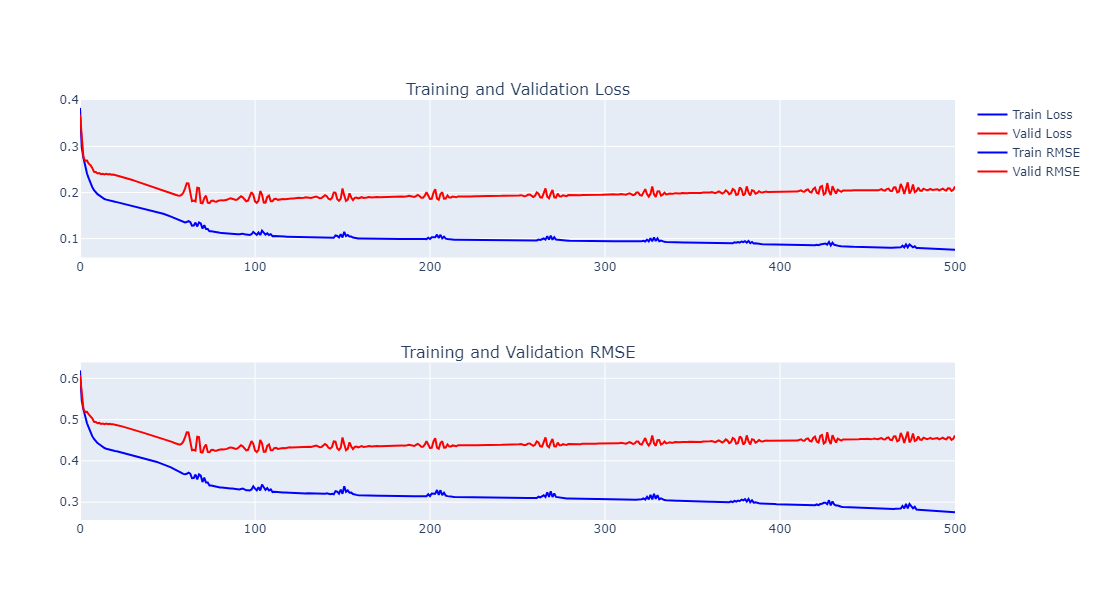

In [33]:
GRU_input_size = len(features)
GRU_hidden_size = 128
GRU_output_size = 1
GRU_num_layers = 2

GRU_learning_rate = 0.001
GRU_weight_decay = 0.0001
GRU_dropout = 0

GRU_seed = 169
torch.manual_seed(GRU_seed)
GRU_model = BiGRUModel(input_size=GRU_input_size, hidden_size=GRU_hidden_size, output_size=GRU_output_size, num_layers=GRU_num_layers, dropout=GRU_dropout)

GRU_criterion = CustomLoss(alpha=1) # alpha 1 huber loss, alpha 0 mse loss
GRU_optimizer = optim.Adam(GRU_model.parameters(), lr=GRU_learning_rate, weight_decay=GRU_weight_decay)

GRU_n_epochs = 500

GRU_stats_df = train_n_validate(train_loader, valid_loader, GRU_model, GRU_optimizer, GRU_criterion, GRU_n_epochs + 1,
            early_stopping=False, model_save_path=r"saved_GRU")

best_loss_index = int(GRU_stats_df.loc[GRU_stats_df['Valid Loss'].idxmin()]['Epoch'])
best_epoch_loss = GRU_stats_df.loc[best_loss_index]['Valid Loss']
best_rmse_index = int(GRU_stats_df.loc[GRU_stats_df['Valid RMSE'].idxmin()]['Epoch'])
best_epoch_rmse = GRU_stats_df.loc[best_rmse_index]['Valid RMSE']

print(f"Best Epoch (Validation Loss): {best_loss_index}, Value: {best_epoch_loss}")
print(f"Best Epoch (Validation RMSE): {best_rmse_index}, Value: {best_epoch_rmse}")

fig = make_subplots(rows=2, cols=1, subplot_titles=['Training and Validation Loss', 'Training and Validation RMSE'])

fig.add_trace(go.Scatter(x=GRU_stats_df['Epoch'], y=GRU_stats_df['Train Loss'], mode='lines', name='Train Loss', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=GRU_stats_df['Epoch'], y=GRU_stats_df['Valid Loss'], mode='lines', name='Valid Loss', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=GRU_stats_df['Epoch'], y=GRU_stats_df['Train RMSE'], mode='lines', name='Train RMSE', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=GRU_stats_df['Epoch'], y=GRU_stats_df['Valid RMSE'], mode='lines', name='Valid RMSE', line=dict(color='red')), row=2, col=1)

fig.update_layout(
    height=600,
    showlegend=True,
)

fig.show()

In [34]:
print("Best epoch was:", best_loss_index)
path = fr"saved_GRU\model_epoch_{best_loss_index}.pth"
GRU_model.load_state_dict(torch.load(path))

Best epoch was: 70


<All keys matched successfully>

In [35]:
torch.save(GRU_model, fr"MODELS\proto_GRU_model.pth")

### LSTM

Epochs:   0%|▏                                                                         | 1/500 [00:00<03:28,  2.39it/s]

Epoch 0: Train Loss 0.5558, Train RMSE 0.7455 | Valid Loss 0.5941, Valid RMSE 0.7708


Epochs:  10%|███████▌                                                                 | 52/500 [00:08<01:04,  6.89it/s]

Epoch 50: Train Loss 0.2160, Train RMSE 0.4648 | Valid Loss 0.2952, Valid RMSE 0.5433


Epochs:  20%|██████████████▋                                                         | 102/500 [00:15<01:02,  6.33it/s]

Epoch 100: Train Loss 0.1668, Train RMSE 0.4084 | Valid Loss 0.2681, Valid RMSE 0.5177


Epochs:  30%|█████████████████████▉                                                  | 152/500 [00:22<00:45,  7.64it/s]

Epoch 150: Train Loss 0.1484, Train RMSE 0.3853 | Valid Loss 0.2531, Valid RMSE 0.5031


Epochs:  40%|█████████████████████████████                                           | 202/500 [00:28<00:35,  8.45it/s]

Epoch 200: Train Loss 0.1463, Train RMSE 0.3824 | Valid Loss 0.2647, Valid RMSE 0.5145


Epochs:  50%|████████████████████████████████████▏                                   | 251/500 [00:37<00:55,  4.50it/s]

Epoch 250: Train Loss 0.1398, Train RMSE 0.3739 | Valid Loss 0.2633, Valid RMSE 0.5131


Epochs:  60%|███████████████████████████████████████████▎                            | 301/500 [00:49<00:42,  4.64it/s]

Epoch 300: Train Loss 0.1375, Train RMSE 0.3707 | Valid Loss 0.2560, Valid RMSE 0.5060


Epochs:  70%|██████████████████████████████████████████████████▌                     | 351/500 [01:00<00:33,  4.42it/s]

Epoch 350: Train Loss 0.1293, Train RMSE 0.3596 | Valid Loss 0.2541, Valid RMSE 0.5041


Epochs:  80%|█████████████████████████████████████████████████████████▉              | 402/500 [01:12<00:19,  4.94it/s]

Epoch 400: Train Loss 0.1308, Train RMSE 0.3616 | Valid Loss 0.2629, Valid RMSE 0.5127


Epochs:  90%|████████████████████████████████████████████████████████████████▉       | 451/500 [01:22<00:10,  4.88it/s]

Epoch 450: Train Loss 0.1286, Train RMSE 0.3585 | Valid Loss 0.2594, Valid RMSE 0.5093


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:36<00:00,  5.20it/s]

Best Epoch (Validation Loss): 159, Value: 0.2467806000478756
Best Epoch (Validation RMSE): 159, Value: 0.4967701682346431


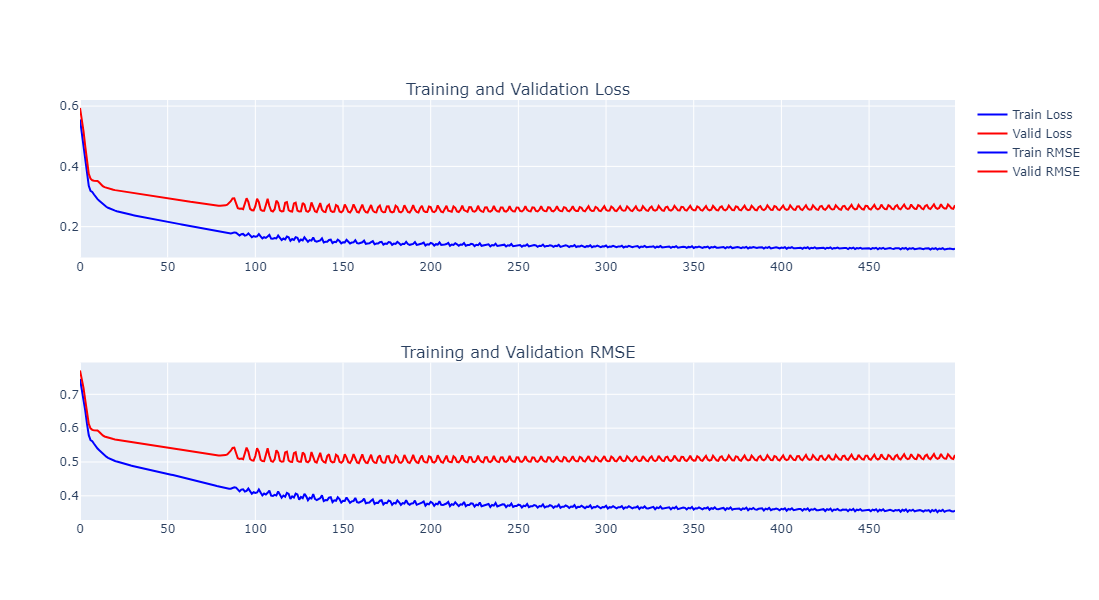

In [36]:
LSTM_input_size = len(features)
LSTM_hidden_size = 64
LSTM_output_size = 1
LSTM_num_layers = 2

LSTM_learning_rate = 0.001
LSTM_weight_decay = 0.0001

LSTM_seed = 123
torch.manual_seed(LSTM_seed)
LSTM_model = BiLSTMModel(input_size=LSTM_input_size, hidden_size=LSTM_hidden_size, output_size=LSTM_output_size, num_layers=LSTM_num_layers)

LSTM_criterion = CustomLoss(alpha=0.7)
LSTM_optimizer = optim.Adam(LSTM_model.parameters(), lr=LSTM_learning_rate, weight_decay=LSTM_weight_decay)

LSTM_n_epochs = 500

LSTM_stats_df = train_n_validate(train_loader, valid_loader, LSTM_model, LSTM_optimizer, LSTM_criterion, LSTM_n_epochs,
                    early_stopping=False, model_save_path=r"saved_LSTM")

best_loss_index = int(LSTM_stats_df.loc[LSTM_stats_df['Valid Loss'].idxmin()]['Epoch'])
best_epoch_loss = LSTM_stats_df.loc[best_loss_index]['Valid Loss']
best_rmse_index = int(LSTM_stats_df.loc[LSTM_stats_df['Valid RMSE'].idxmin()]['Epoch'])
best_epoch_rmse = LSTM_stats_df.loc[best_rmse_index]['Valid RMSE']

print(f"Best Epoch (Validation Loss): {best_loss_index}, Value: {best_epoch_loss}")
print(f"Best Epoch (Validation RMSE): {best_rmse_index}, Value: {best_epoch_rmse}")

fig = make_subplots(rows=2, cols=1, subplot_titles=['Training and Validation Loss', 'Training and Validation RMSE'])

fig.add_trace(go.Scatter(x=LSTM_stats_df['Epoch'], y=LSTM_stats_df['Train Loss'], mode='lines', name='Train Loss', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=LSTM_stats_df['Epoch'], y=LSTM_stats_df['Valid Loss'], mode='lines', name='Valid Loss', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=LSTM_stats_df['Epoch'], y=LSTM_stats_df['Train RMSE'], mode='lines', name='Train RMSE', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=LSTM_stats_df['Epoch'], y=LSTM_stats_df['Valid RMSE'], mode='lines', name='Valid RMSE', line=dict(color='red')), row=2, col=1)

fig.update_layout(
    height=600,
    showlegend=True,
)

fig.show()

In [37]:
print("Best epoch was:", best_loss_index)
path = fr"saved_LSTM\model_epoch_{best_loss_index}.pth"
LSTM_model.load_state_dict(torch.load(path))

Best epoch was: 159


<All keys matched successfully>

In [38]:
torch.save(LSTM_model, fr"MODELS\proto_LSTM_model.pth")

# PHASE 4: Testing

In [39]:
GRU_model.eval()
LSTM_model.eval()
print("")

## Plot inference

In [40]:
desired_column = "NetAmountWOVat"

In [41]:
result_train_df = pd.DataFrame({'Time': train_df.index[:len(X_train)], desired_column: resampled_df[desired_column].iloc[:len(X_train)]})
result_valid_df = pd.DataFrame({'Time': valid_df.index[-len(X_valid):], desired_column: resampled_df[desired_column].iloc[-len(X_valid):]})

mean = train_original_stats[desired_column]["mean"]
std = train_original_stats[desired_column]["std"]

#################################### GRU ######################################################
train_predictions_GRU = []
for sequence, target in train_dataset:
    sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
    y_pred = GRU_model(sequence_tensor).item()
    train_predictions_GRU.append(y_pred)

train_predictions_GRU = np.array(train_predictions_GRU)

train_predictions_GRU_denorm = (train_predictions_GRU * std) + mean
result_train_df[f'{desired_column} GRU'] = train_predictions_GRU_denorm


valid_predictions_GRU = []
for sequence, target in valid_dataset:
    sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
    y_pred = GRU_model(sequence_tensor).item()
    valid_predictions_GRU.append(y_pred)

valid_predictions_GRU = np.array(valid_predictions_GRU)

valid_predictions_GRU_denorm = (valid_predictions_GRU * std) + mean
result_valid_df[f'{desired_column} GRU'] = valid_predictions_GRU_denorm

#################################### LSTM ######################################################
train_predictions_LSTM = []
for sequence, target in train_dataset:
    sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
    y_pred = LSTM_model(sequence_tensor).item()
    train_predictions_LSTM.append(y_pred)

train_predictions_LSTM = np.array(train_predictions_LSTM)

train_predictions_LSTM_denorm = (train_predictions_LSTM * std) + mean
result_train_df[f'{desired_column} LSTM'] = train_predictions_LSTM_denorm

valid_predictions_LSTM = []
for sequence, target in valid_dataset:
    sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
    y_pred = LSTM_model(sequence_tensor).item()
    valid_predictions_LSTM.append(y_pred)

valid_predictions_LSTM = np.array(valid_predictions_LSTM)

valid_predictions_LSTM_denorm = (valid_predictions_LSTM * std) + mean
result_valid_df[f'{desired_column} LSTM'] = valid_predictions_LSTM_denorm

#################################### Ensemble ######################################################
train_predictions_ensemble = (train_predictions_GRU_denorm + train_predictions_LSTM_denorm) / 2
valid_predictions_ensemble = (valid_predictions_GRU_denorm + valid_predictions_LSTM_denorm) / 2

result_train_df[f'{desired_column} Ensemble'] = train_predictions_ensemble
result_valid_df[f'{desired_column} Ensemble'] = valid_predictions_ensemble

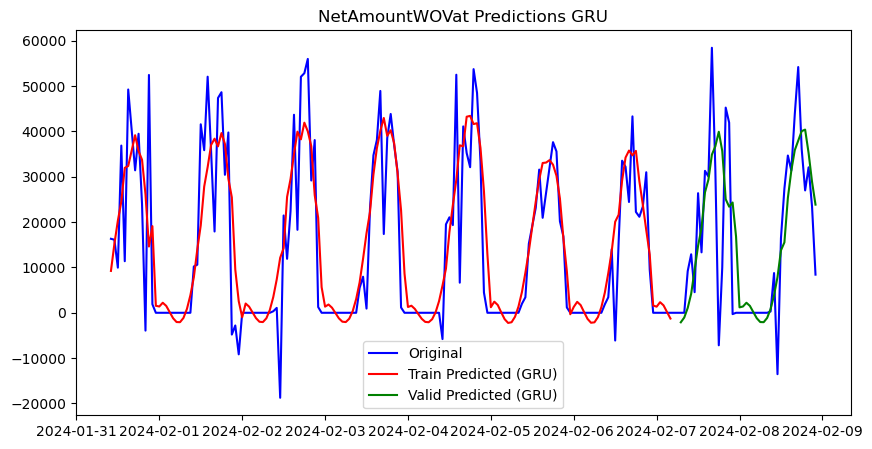

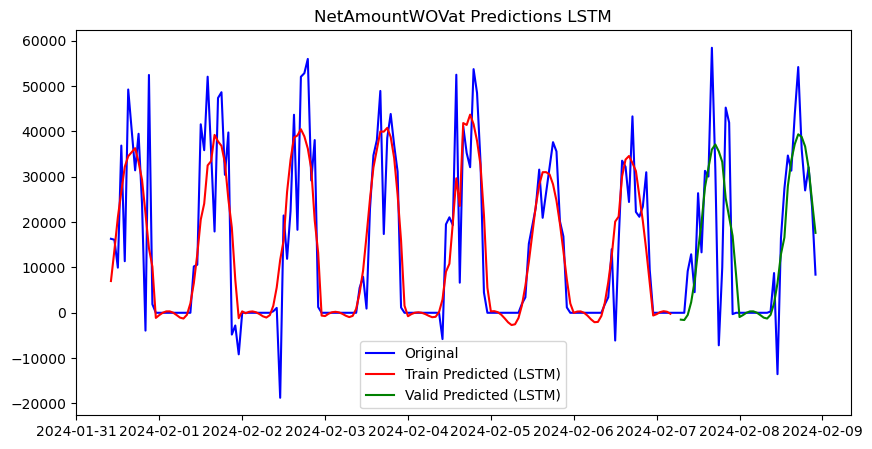

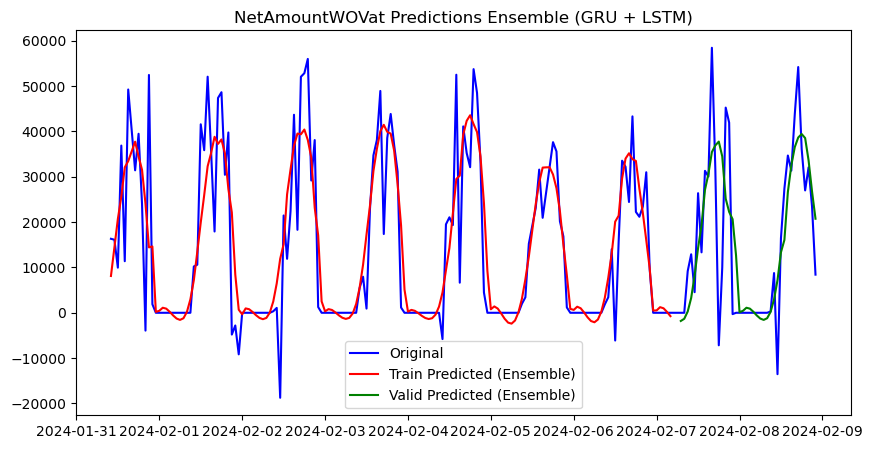

In [42]:
    # GRU
plt.figure(figsize=(10, 5))
plt.plot(resampled_df.index, resampled_df[f'{desired_column}'], label='Original', c='b')
plt.plot(result_train_df['Time'], result_train_df[f'{desired_column} GRU'], label='Train Predicted (GRU)', c='r')
plt.plot(result_valid_df['Time'], result_valid_df[f'{desired_column} GRU'], label='Valid Predicted (GRU)', c='g')
plt.title(f'{desired_column} Predictions GRU')
plt.legend()
    # LSTM
plt.figure(figsize=(10, 5))
plt.plot(resampled_df.index, resampled_df[f'{desired_column}'], label='Original', c='b')
plt.plot(result_train_df['Time'], result_train_df[f'{desired_column} LSTM'], label='Train Predicted (LSTM)', c='r')
plt.plot(result_valid_df['Time'], result_valid_df[f'{desired_column} LSTM'], label='Valid Predicted (LSTM)', c='g')
plt.title(f'{desired_column} Predictions LSTM')
plt.legend()
    # Ensemble
plt.figure(figsize=(10, 5))
plt.plot(resampled_df.index, resampled_df[f'{desired_column}'], label='Original', c='b')
plt.plot(result_train_df['Time'], result_train_df[f'{desired_column} Ensemble'], label='Train Predicted (Ensemble)', c='r')
plt.plot(result_valid_df['Time'], result_valid_df[f'{desired_column} Ensemble'], label='Valid Predicted (Ensemble)', c='g')
plt.title(f'{desired_column} Predictions Ensemble (GRU + LSTM)')
plt.legend()

plt.show()

## Table Inference

In [43]:
result_df = pd.concat([result_train_df, result_valid_df], ignore_index=True)
result_df.tail(30)

Time  NetAmountWOVat  NetAmountWOVat GRU  \
171 2024-02-07 17:00:00        31651.27        36723.613572   
172 2024-02-07 18:00:00        -7171.68        39933.070436   
173 2024-02-07 19:00:00        10000.07        35691.686705   
174 2024-02-07 20:00:00        45257.45        25047.289592   
175 2024-02-07 21:00:00        41939.75        23402.721527   
176 2024-02-07 22:00:00         -290.14        24325.862255   
177 2024-02-07 23:00:00            0.00        16786.388150   
178 2024-02-08 00:00:00            0.00         1194.476491   
179 2024-02-08 01:00:00            0.00         1387.527982   
180 2024-02-08 02:00:00            0.00         2213.627375   
181 2024-02-08 03:00:00            0.00         1525.950403   
182 2024-02-08 04:00:00            0.00          146.446231   
183 2024-02-08 05:00:00            0.00        -1204.664390   
184 2024-02-08 06:00:00            0.00        -2042.418225   
185 2024-02-08 07:00:00            0.00        -2073.189866   
186 2024-02-08 08:00:00            0.00        -1133.046388   
187 2024-02-08 09:00:00          291.61          848.874370   
188 2024-02-08 10:00:00         8764.06         3865.568898   
189 2024-02-08 11:00:00       -13541.08         7868.299130   
190 2024-02-08 12:00:00        16478.08        13768.798184   
191 2024-02-08 13:00:00        27416.69        15528.069771   
192 2024-02-08 14:00:00        34684.19        25338.132947   
193 2024-02-08 15:00:00        31353.18        31369.953973   
194 2024-02-08 16:00:00        43761.77        35867.892780   
195 2024-02-08 17:00:00        54206.70        37966.983052   
196 2024-02-08 18:00:00        36130.63        40065.086794   
197 2024-02-08 19:00:00        26992.63        40408.037616   
198 2024-02-08 20:00:00        32083.99        35249.143178   
199 2024-02-08 21:00:00        23429.17        28889.521149   
200 2024-02-08 22:00:00         8413.79        23857.185264   

     NetAmountWOVat LSTM  NetAmountWOVat Ensemble  
171         37127.486843             36925.550208  
172         35590.803433             37761.936935  
173         33282.800657             34487.243681  
174         25274.560263             25160.924927  
175         21096.660449             22249.690988  
176         16956.608872             20641.235563  
177          8444.265457             12615.326803  
178          -937.975062               128.250714  
179          -510.663210               438.432386  
180             8.310839              1110.969107  
181           305.068055               915.509229  
182           316.662966               231.554598  
183            30.951053              -586.856668  
184          -494.198373             -1268.308299  
185         -1066.683143             -1569.936505  
186         -1268.747347             -1200.896867  
187          -446.821570               201.026400  
188          2066.922572              2966.245735  
189          6536.641639              7202.470385  
190         12923.240679             13346.019432  
191         16619.505469             16073.787620  
192         27956.276998             26647.204972  
193         33643.119926             32506.536950  
194         37218.334729             36543.113755  
195         39364.595568             38665.789310  
196         38791.113638             39428.100216  
197         36682.166576             38545.102096  
198         31946.093580             33597.618379  
199         24612.781816             26751.151482  
200         17629.809215             20743.497239

In [44]:
result_df["Original_Status"] = np.where(result_df[f"{desired_column}"].shift(-1) > result_df[f"{desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_GRU"] = np.where(result_df[f"{desired_column} GRU"].shift(-1) > result_df[f"{desired_column} GRU"], "Will Rise", "Will Fall")
result_df["Predicted_Status_LSTM"] = np.where(result_df[f"{desired_column} LSTM"].shift(-1) > result_df[f"{desired_column} LSTM"], "Will Rise", "Will Fall")

result_df.head(100)

Time  NetAmountWOVat  NetAmountWOVat GRU  \
0  2024-01-31 10:00:00        16321.85         9234.194405   
1  2024-01-31 11:00:00        16112.86        15212.674802   
2  2024-01-31 12:00:00         9955.61        20320.977710   
3  2024-01-31 13:00:00        36883.48        24499.262887   
4  2024-01-31 14:00:00        11374.87        31970.707916   
5  2024-01-31 15:00:00        49252.87        32371.351579   
6  2024-01-31 17:00:00        31425.66        39176.147172   
7  2024-01-31 18:00:00        39486.80        35657.028478   
8  2024-01-31 19:00:00        24004.20        33759.432605   
9  2024-01-31 20:00:00        -3930.48        26130.670138   
10 2024-01-31 21:00:00        52459.47        14617.708680   
11 2024-01-31 22:00:00         1879.17        19108.523386   
12 2024-01-31 23:00:00            0.00         1543.980080   
13 2024-02-01 00:00:00            0.00         1387.527982   
14 2024-02-01 01:00:00            0.00         2213.627375   
15 2024-02-01 02:00:00            0.00         1525.950403   
16 2024-02-01 03:00:00            0.00          146.446231   
17 2024-02-01 04:00:00            0.00        -1204.664390   
18 2024-02-01 05:00:00            0.00        -2042.418225   
19 2024-02-01 06:00:00            0.00        -2073.189866   
20 2024-02-01 07:00:00            0.00        -1133.046388   
21 2024-02-01 08:00:00            0.00          848.874370   
22 2024-02-01 09:00:00            0.00         3865.568898   
23 2024-02-01 10:00:00        10213.80         7830.629756   
24 2024-02-01 11:00:00        10608.78        13960.416391   
25 2024-02-01 12:00:00        41577.63        19284.275530   
26 2024-02-01 13:00:00        35860.47        27835.818344   
27 2024-02-01 14:00:00        52076.60        32139.974267   
28 2024-02-01 15:00:00        35542.99        37023.950147   
29 2024-02-01 16:00:00        17930.29        38402.089337   
30 2024-02-01 17:00:00        47382.29        36707.818469   
31 2024-02-01 18:00:00        48652.41        39640.866351   
32 2024-02-01 19:00:00        30437.08        37241.150350   
33 2024-02-01 20:00:00        39773.96        29563.941631   
34 2024-02-01 21:00:00        -4807.72        25462.349555   
35 2024-02-01 22:00:00        -2797.72         9540.079942   
36 2024-02-01 23:00:00        -9165.83         2553.471905   
37 2024-02-02 00:00:00            0.00         -989.631788   
38 2024-02-02 01:00:00            0.00         2042.049909   
39 2024-02-02 02:00:00            0.00         1355.414746   
40 2024-02-02 03:00:00            0.00           70.347386   
41 2024-02-02 04:00:00            0.00        -1184.037631   
42 2024-02-02 05:00:00            0.00        -1980.439084   
43 2024-02-02 06:00:00            0.00        -2047.944066   
44 2024-02-02 07:00:00            0.00        -1216.230598   
45 2024-02-02 08:00:00            0.00          612.766394   
46 2024-02-02 09:00:00          333.32         3470.034353   
47 2024-02-02 10:00:00         1078.03         7349.909238   
48 2024-02-02 11:00:00       -18747.92        12136.016715   
49 2024-02-02 12:00:00        21466.35        14268.679752   
50 2024-02-02 13:00:00        11907.53        25557.696356   
51 2024-02-02 14:00:00        22420.94        29505.700246   
52 2024-02-02 15:00:00        43681.18        35037.358257   
53 2024-02-02 16:00:00        18301.91        39960.395603   
54 2024-02-02 17:00:00        52060.01        38253.055346   
55 2024-02-02 18:00:00        52848.88        41931.821728   
56 2024-02-02 19:00:00        55993.66        40015.537074   
57 2024-02-02 20:00:00        29179.96        36754.266149   
58 2024-02-02 21:00:00        38099.98        25950.582792   
59 2024-02-02 22:00:00         1267.42        20941.399522   
60 2024-02-02 23:00:00            0.00         5647.859884   
61 2024-02-03 00:00:00            0.00         1357.136920   
62 2024-02-03 01:00:00            0.00         1822.230300   
63 2024-02-03 02:00:00            0.00         112

In [45]:
real_values = result_df[f'{desired_column}'].sum()
GRU_values = result_df[f'{desired_column} GRU'].sum()
LSTM_values = result_df[f'{desired_column} LSTM'].sum()
Ensemble_values = result_df[f'{desired_column} Ensemble'].sum()

print(f"Real {desired_column}:", real_values)
print(f"GRU {desired_column}:", GRU_values, f", LSTM {desired_column}:", LSTM_values, f", Ensemble {desired_column}:", Ensemble_values)

print("-------------------------------------------")

print("The prediction offness:")
print("GRU:", int(GRU_values - real_values), ", LSTM:", int(LSTM_values - real_values), ", Ensemble:", int(Ensemble_values - real_values))

Real NetAmountWOVat: 2832452.5700000003
GRU NetAmountWOVat: 3132542.982442159 , LSTM NetAmountWOVat: 2844012.107194555 , Ensemble NetAmountWOVat: 2988277.544818357
-------------------------------------------
The prediction offness:
GRU: 300090 , LSTM: 11559 , Ensemble: 155824


Text(0, 0.5, 'Absolute Distance')

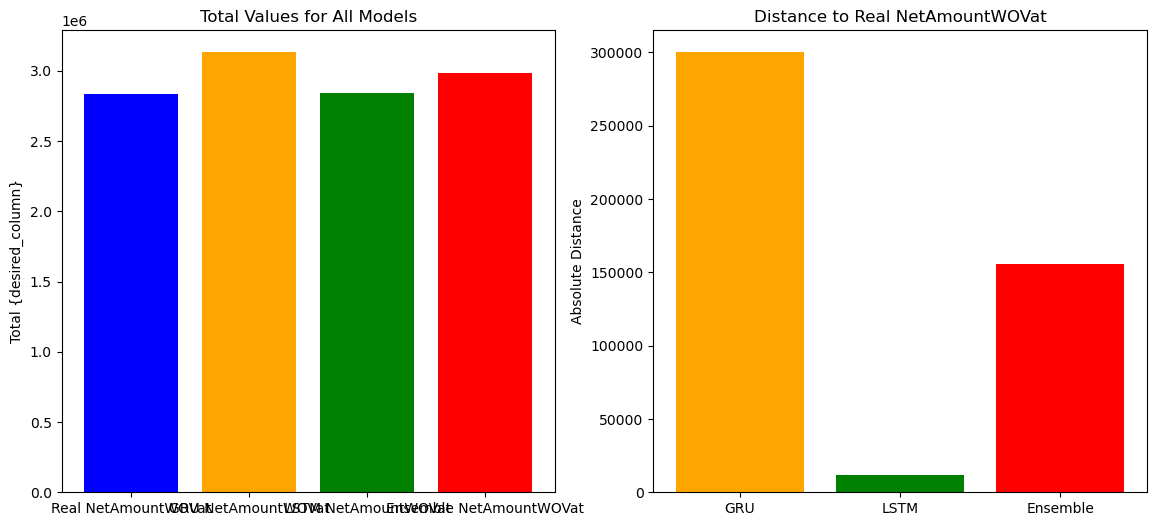

In [46]:
distance_GRU = GRU_values - real_values
distance_LSTM = LSTM_values - real_values
distance_Ensemble = Ensemble_values - real_values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].bar([f'Real {desired_column}', f'GRU {desired_column}', f'LSTM {desired_column}', f'Ensemble {desired_column}'],
            [real_values, GRU_values, LSTM_values, Ensemble_values],
            color=['blue', 'orange', 'green', 'red'])
axes[0].set_title('Total Values for All Models')
axes[0].set_ylabel('Total {desired_column}')

axes[1].bar(['GRU', 'LSTM', 'Ensemble'],
            [distance_GRU, distance_LSTM, distance_Ensemble],
            color=['orange', 'green', 'red'])
axes[1].set_title(f'Distance to Real {desired_column}')
axes[1].set_ylabel('Absolute Distance')

# PHASE 5: Forecasting

## Prepare the emtpy set

In [47]:
start_timestamp = '2024-02-08 21:00:00'
end_timestamp = '2024-02-18 23:00:00'

forecast_timestamps = pd.date_range(start=start_timestamp, end=end_timestamp, freq='H')

forecast_df = pd.DataFrame(index=forecast_timestamps)

forecast_df[f'Forecasted {desired_column}'] = np.nan
forecast_df[f'{desired_column} Before'] = np.nan

forecast_df["HourInterval"] = forecast_df.index.hour
forecast_df['DayOfWeek'] = forecast_df.index.dayofweek + 1

forecast_df = forecast_df[[f'Forecasted {desired_column}', 'HourInterval', 'DayOfWeek', f'{desired_column} Before']]

forecast_df.head(4)

Forecasted NetAmountWOVat  HourInterval  DayOfWeek  \
2024-02-08 21:00:00                        NaN            21          4   
2024-02-08 22:00:00                        NaN            22          4   
2024-02-08 23:00:00                        NaN            23          4   
2024-02-09 00:00:00                        NaN             0          5   

                     NetAmountWOVat Before  
2024-02-08 21:00:00                    NaN  
2024-02-08 22:00:00                    NaN  
2024-02-08 23:00:00                    NaN  
2024-02-09 00:00:00                    NaN

In [48]:
forecast_df.iloc[:sequence_length] = valid_df.iloc[-sequence_length:]
forecast_df.iloc[sequence_length, forecast_df.columns.get_loc(f'{desired_column} Before')] = forecast_df.iloc[sequence_length-1][f'Forecasted {desired_column}']

In [49]:
print(forecast_df.shape)
forecast_df.head(50)

(243, 4)


Forecasted NetAmountWOVat  HourInterval  DayOfWeek  \
2024-02-08 21:00:00                  -0.287751            22          4   
2024-02-08 22:00:00                        NaN            22          4   
2024-02-08 23:00:00                        NaN            23          4   
2024-02-09 00:00:00                        NaN             0          5   
2024-02-09 01:00:00                        NaN             1          5   
2024-02-09 02:00:00                        NaN             2          5   
2024-02-09 03:00:00                        NaN             3          5   
2024-02-09 04:00:00                        NaN             4          5   
2024-02-09 05:00:00                        NaN             5          5   
2024-02-09 06:00:00                        NaN             6          5   
2024-02-09 07:00:00                        NaN             7          5   
2024-02-09 08:00:00                        NaN             8          5   
2024-02-09 09:00:00                        NaN             9          5   
2024-02-09 10:00:00                        NaN            10          5   
2024-02-09 11:00:00                        NaN            11          5   
2024-02-09 12:00:00                        NaN            12          5   
2024-02-09 13:00:00                        NaN            13          5   
2024-02-09 14:00:00                        NaN            14          5   
2024-02-09 15:00:00                        NaN            15          5   
2024-02-09 16:00:00                        NaN            16          5   
2024-02-09 17:00:00                        NaN            17          5   
2024-02-09 18:00:00                        NaN            18          5   
2024-02-09 19:00:00                        NaN            19          5   
2024-02-09 20:00:00                        NaN            20          5   
2024-02-09 21:00:00                        NaN            21          5   
2024-02-09 22:00:00                        NaN            22          5   
2024-02-09 23:00:00                        NaN            23          5   
2024-02-10 00:00:00                        NaN             0          6   
2024-02-10 01:00:00                        NaN             1          6   
2024-02-10 02:00:00                        NaN             2          6   
2024-02-10 03:00:00                        NaN             3          6   
2024-02-10 04:00:00                        NaN             4          6   
2024-02-10 05:00:00                        NaN             5          6   
2024-02-10 06:00:00                        NaN             6          6   
2024-02-10 07:00:00                        NaN             7          6   
2024-02-10 08:00:00                        NaN             8          6   
2024-02-10 09:00:00                        NaN             9          6   
2024-02-10 10:00:00                        NaN            10          6   
2024-02-10 11:00:00                        NaN            11          6   
2024-02-10 12:00:00                        NaN            12          6   
2024-02-10 13:00:00                        NaN            13          6   
2024-02-10 14:00:00                        NaN            14          6   
2024-02-10 15:00:00                        NaN            15          6   
2024-02-10 16:00:00                        NaN            16          6   
2024-02-10 17:00:00                        NaN            17          6   
2024-02-10 18:00:00                        NaN            18          6   
2024-02-10 19:00:00                        NaN            19          6   
2024-02-10 20:00:00                        NaN            20          6   
2024-02-10 21:00:00                        NaN            21          6   
2024-02-10 22:00:00                        NaN            22          6   

                     NetAmountWOVat Before  
2024-02-08 21:00:00               0.554137  
2024-02-08 22:00:00              -0.287751  
2024-02-08 23:00:00                    NaN  
2024-02-09 00:0

## Forecasts

In [50]:
GRU_forecast_df = forecast_df.copy()
LSTM_forecast_df = forecast_df.copy()

In [51]:
############################## GRU ###########################################
for i in range(sequence_length, len(forecast_df) + 100):
    sequence = GRU_forecast_df.iloc[i:i + sequence_length]
    sequence = sequence[features].values

    torch_input = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)

    predicted_value = GRU_model(torch_input)

    GRU_forecast_df.iloc[i, GRU_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    if GRU_forecast_df.isnull().sum()[0] == 0:
        break

    GRU_forecast_df.iloc[i + 1, GRU_forecast_df.columns.get_loc(f'{desired_column} Before')] = GRU_forecast_df.iloc[i, GRU_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

############################## LSTM ###########################################
for i in range(sequence_length, len(forecast_df) + 100):
    sequence = LSTM_forecast_df.iloc[i:i + sequence_length]
    sequence = sequence[features].values

    torch_input = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)

    predicted_value = LSTM_model(torch_input)

    LSTM_forecast_df.iloc[i, LSTM_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    if LSTM_forecast_df.isnull().sum()[0] == 0:
        break

    LSTM_forecast_df.iloc[i + 1, LSTM_forecast_df.columns.get_loc(f'{desired_column} Before')] = LSTM_forecast_df.iloc[i, LSTM_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

################################# Ensemble ###############################################
GRU_forecast_df_denorm = GRU_forecast_df.copy()
LSTM_forecast_df_denorm = LSTM_forecast_df.copy()

GRU_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before']] = (GRU_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before']] * std) + mean
LSTM_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before']] = (LSTM_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before']] * std) + mean

ensemble_forecast_df_denorm = pd.DataFrame(index=GRU_forecast_df_denorm.index)

ensemble_forecast_df_denorm[f'Ensemble Forecasted {desired_column}'] = (GRU_forecast_df_denorm[f'Forecasted {desired_column}'] + LSTM_forecast_df_denorm[f'Forecasted {desired_column}']) / 2

## Plot Inference

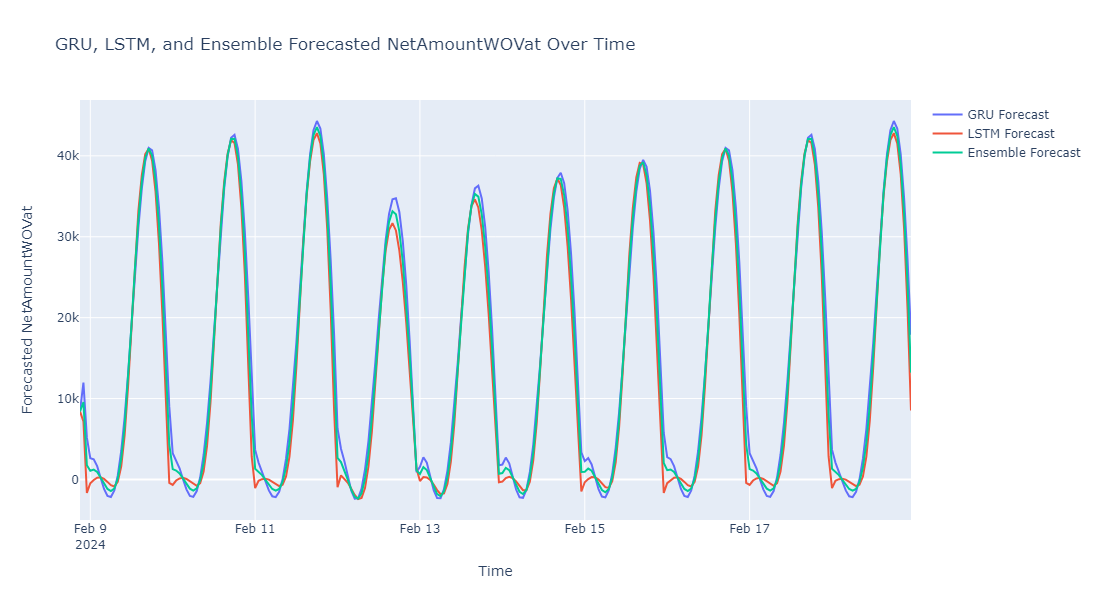

In [52]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=GRU_forecast_df_denorm.index, y=GRU_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='GRU Forecast'))

fig.add_trace(go.Scatter(x=LSTM_forecast_df_denorm.index, y=LSTM_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='LSTM Forecast'))

fig.add_trace(go.Scatter(x=ensemble_forecast_df_denorm.index, y=ensemble_forecast_df_denorm[f'Ensemble Forecasted {desired_column}'], mode='lines', name='Ensemble Forecast'))

fig.update_layout(title=f'GRU, LSTM, and Ensemble Forecasted {desired_column} Over Time',
                  xaxis_title='Time',
                  yaxis_title=f'Forecasted {desired_column}',
                  width=1100,
                  height=600,
                  showlegend=True)

fig.show()

## Table Inference

In [53]:
predictions_df = pd.concat([GRU_forecast_df_denorm[f'Forecasted {desired_column}'], LSTM_forecast_df_denorm[f'Forecasted {desired_column}'], ensemble_forecast_df_denorm[f'Ensemble Forecasted {desired_column}']], axis=1)
predictions_df.columns = [f'GRU Forecasted {desired_column}', f'LSTM Forecasted {desired_column}', f'Ensemble Forecasted {desired_column}']

predictions_df

GRU Forecasted NetAmountWOVat  \
2024-02-08 21:00:00                    8413.790000   
2024-02-08 22:00:00                   11984.734861   
2024-02-08 23:00:00                    5167.661334   
2024-02-09 00:00:00                    2622.150517   
2024-02-09 01:00:00                    2493.466886   
2024-02-09 02:00:00                    1646.511112   
2024-02-09 03:00:00                     203.977484   
2024-02-09 04:00:00                   -1171.373271   
2024-02-09 05:00:00                   -2045.181146   
2024-02-09 06:00:00                   -2166.522148   
2024-02-09 07:00:00                   -1363.882597   
2024-02-09 08:00:00                     498.990202   
2024-02-09 09:00:00                    3520.352672   
2024-02-09 10:00:00                    7723.230393   
2024-02-09 11:00:00                   12994.313260   
2024-02-09 12:00:00                   19020.898199   
2024-02-09 13:00:00                   25276.668332   
2024-02-09 14:00:00                   31115.897113   
2024-02-09 15:00:00                   35945.212030   
2024-02-09 16:00:00                   39331.285315   
2024-02-09 17:00:00                   40980.095032   
2024-02-09 18:00:00                   40672.450910   
2024-02-09 19:00:00                   38241.027765   
2024-02-09 20:00:00                   33609.833060   
2024-02-09 21:00:00                   26885.156845   
2024-02-09 22:00:00                   18454.445822   
2024-02-09 23:00:00                    8997.548515   
2024-02-10 00:00:00                    3252.220758   
2024-02-10 01:00:00                    2331.630336   
2024-02-10 02:00:00                    1380.346941   
2024-02-10 03:00:00                      34.370951   
2024-02-10 04:00:00                   -1224.289736   
2024-02-10 05:00:00                   -2026.697538   
2024-02-10 06:00:00                   -2148.887933   
2024-02-10 07:00:00                   -1431.903168   
2024-02-10 08:00:00                     261.990309   
2024-02-10 09:00:00                    3052.867384   
2024-02-10 10:00:00                    7010.217791   
2024-02-10 11:00:00                   12090.240895   
2024-02-10 12:00:00                   18060.983201   
2024-02-10 13:00:00                   24458.819430   
2024-02-10 14:00:00                   30644.970665   
2024-02-10 15:00:00                   35974.599553   
2024-02-10 16:00:00                   39950.872616   
2024-02-10 17:00:00                   42241.404891   
2024-02-10 18:00:00                   42608.466154   
2024-02-10 19:00:00                   40862.245153   
2024-02-10 20:00:00                   36878.575245   
2024-02-10 21:00:00                   30678.422307   
2024-02-10 22:00:00                   22541.048603   
2024-02-10 23:00:00                   13069.324052   
2024-02-11 00:00:00                    3686.945400   
2024-02-11 01:00:00                    2082.233977   
2024-02-11 02:00:00                    1057.178799   
2024-02-11 03:00:00                    -200.480476   
2024-02-11 04:00:00                   -1349.515198   
2024-02-11 05:00:00                   -2076.081418   
2024-02-11 06:00:00                   -2183.134752   
2024-02-11 07:00:00                   -1530.135142   
2024-02-11 08:00:00                      10.273267   
2024-02-11 09:00:00                    2564.966888   
2024-02-11 10:00:00                    6237.582343   
2024-02-11 11:00:00                   11050.087722   
2024-02-11 12:00:00                   16861.125998   
2024-02-11 13:00:00                   23296.730201   
2024-02-11 14:00:00                   29760.930736   
2024-02-11 15:00:00                   35576.975011   
2024-02-11 16:00:00                   40176.711331   
2024-02-11 17:00:00                   43173.855991   
2024-02-11 18:00:00                   44306.810707   
2024-02-11 19:00:00                   43369.159066   
2024-02-11 20:00:00                   40199.605619   
2024-02-11 21:00:00                   34739.613448   
2024-02-11 22:00:00      

In [54]:
predictions_by_day = predictions_df.groupby(pd.Grouper(freq='D')).sum()  

In [55]:
predictions_by_day

GRU Forecasted NetAmountWOVat  LSTM Forecasted NetAmountWOVat  \
2024-02-08                   25566.186194                    13929.362728   
2024-02-09                  383486.552300                   348607.802001   
2024-02-10                  400551.838859                   361410.824394   
2024-02-11                  415842.802743                   370444.986403   
2024-02-12                  325912.307931                   267683.319154   
2024-02-13                  333641.355028                   293324.249831   
2024-02-14                  349285.310636                   314683.131470   
2024-02-15                  366226.395735                   332989.542137   
2024-02-16                  383645.295315                   348608.390942   
2024-02-17                  400551.838859                   361410.824394   
2024-02-18                  415842.802743                   370444.986403   

            Ensemble Forecasted NetAmountWOVat  
2024-02-08                        19747.774461  
2024-02-09                       366047.177150  
2024-02-10                       380981.331626  
2024-02-11                       393143.894573  
2024-02-12                       296797.813543  
2024-02-13                       313482.802430  
2024-02-14                       331984.221053  
2024-02-15                       349607.968936  
2024-02-16                       366126.843128  
2024-02-17                       380981.331626  
2024-02-18                       393143.894573

# PHASE 6: Explainable AI

## Torch Visualization

In [56]:
from torchviz import make_dot

dummy_input = Variable(torch.randn(1, sequence_length, len(features)), requires_grad=True)  

graph_GRU = make_dot(GRU_model(dummy_input), params=dict(GRU_model.named_parameters()), show_attrs=True, show_saved=True)

graph_GRU.render("RNN Model Graphs\proto_GRU_model_graph", format="png", cleanup=True)

'RNN Model Graphs\\proto_GRU_model_graph.png'

In [57]:
from torchviz import make_dot

dummy_input = Variable(torch.randn(1, sequence_length, len(features)), requires_grad=True) 

graph_LSTM = make_dot(LSTM_model(dummy_input), params=dict(LSTM_model.named_parameters()), show_attrs=True, show_saved=True)

graph_LSTM.render("RNN Model Graphs\proto_LSTM_model_graph", format="png", cleanup=True)

'RNN Model Graphs\\proto_LSTM_model_graph.png'

## SHAP

In [58]:
import shap

In [59]:
## GRU ##
def f_gru(f_input):
    with torch.no_grad():
        output = GRU_model(torch.tensor(f_input, dtype=torch.float32).unsqueeze(1)).numpy().flatten()
        return output

explainer_gru = shap.KernelExplainer(f_gru, valid_df[features])

shap_values_gru_valid = explainer_gru.shap_values(valid_df[features])
shap_values_gru_train = explainer_gru.shap_values(train_df[features])

df_shap_gru_valid = pd.DataFrame(shap_values_gru_valid, columns=features)
df_shap_gru_train = pd.DataFrame(shap_values_gru_train, columns=features)

## LSTM ##
def f_lstm(f_input):
    with torch.no_grad():
        output = LSTM_model(torch.tensor(f_input, dtype=torch.float32).unsqueeze(1)).numpy().flatten()
        return output
        
explainer_lstm = shap.KernelExplainer(f_lstm, valid_df[features])

shap_values_lstm_valid = explainer_lstm.shap_values(valid_df[features])
shap_values_lstm_train = explainer_lstm.shap_values(train_df[features])

df_shap_lstm_valid = pd.DataFrame(shap_values_lstm_valid, columns=features)
df_shap_lstm_train = pd.DataFrame(shap_values_lstm_train, columns=features)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

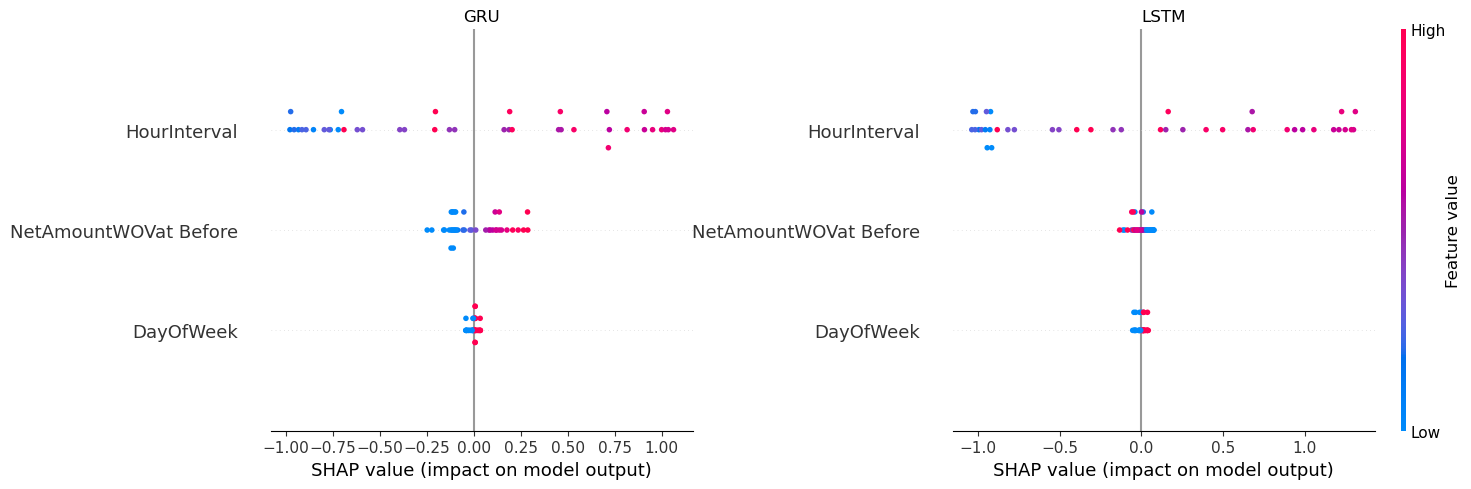

In [60]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_gru_valid, valid_original[features], plot_size=None, show=False)
plt.title('GRU')

plt.subplot(1, 2, 2)
shap.summary_plot(shap_values_lstm_valid, valid_original[features], plot_size=None, show=False)
plt.title('LSTM')
print()

In [61]:
j = 8
sample = valid_df[features].iloc[[j]]
print("Features:", sample)
print("Label:", valid_df[f"{desired_column}"].iloc[[j]].values * std + mean)
print("")

denorm_pred_gru = int(sum(shap_values_gru_valid[j]) * std + mean)
denorm_pred_lstm = int(sum(shap_values_lstm_valid[j]) * std + mean)

shap.initjs()

print("GRU prediction")
print("Denormalized:", denorm_pred_gru)
display(shap.force_plot(explainer_gru.expected_value, shap_values_gru_valid[j], sample))

print("LSTM prediction")
print("Denormalized:", denorm_pred_lstm)
display(shap.force_plot(explainer_lstm.expected_value, shap_values_lstm_valid[j], sample))

print("Ensemble prediction")
print("Denorm amount:", int((denorm_pred_gru + denorm_pred_lstm) / 2))
ensemble_expected = (explainer_gru.expected_value + explainer_lstm.expected_value) / 2
ensemble_values = (shap_values_gru_valid[j] + shap_values_lstm_valid[j]) / 2
display(shap.force_plot(ensemble_expected, ensemble_values, sample))

Features:                      HourInterval  DayOfWeek  NetAmountWOVat Before
TransactionDateTime                                                
2024-02-07 14:00:00            14          3               -0.01199
Label: [31310.19]



GRU prediction
Denormalized: 26003


LSTM prediction
Denormalized: 29831


Ensemble prediction
Denorm amount: 27917
